# Prediction of Used Car Prices Using Gradient Boosting Methods

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

Data description

Features
- DateCrawled — date profile was downloaded from the database
- VehicleType — vehicle body type
- RegistrationYear — vehicle registration year
- Gearbox — gearbox type
- Power — power (hp)
- Model — vehicle model
- Mileage — mileage (measured in km due to dataset's regional specifics)
- RegistrationMonth — vehicle registration month
- FuelType — fuel type
- Brand — vehicle brand
- NotRepaired — vehicle repaired or not
- DateCreated — date of profile creation
- NumberOfPictures — number of vehicle pictures
- PostalCode — postal code of profile owner (user)
- LastSeen — date of the last activity of the user

Target
- Price — price (Euro)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb

## Data preparation

In [2]:
# Read in the data
df = pd.read_csv('datasets/car_data.csv')

In [3]:
# Display data info
display(df.head())
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# Standardize column names
df = df.rename(columns={'DateCrawled':'date_crawled', 
    'Price':'price', 
    'VehicleType':'vehicle_type', 
    'RegistrationYear':'registration_year', 
    'Gearbox':'gearbox', 
    'Power':'power', 
    'Model':'model', 
    'Mileage':'mileage', 
    'RegistrationMonth':'registration_month', 
    'FuelType': 'fuel_type',
    'Brand':'brand',
    'NotRepaired':'not_repaired',
    'DateCreated':'date_created',
    'NumberOfPictures':'number_of_pictures',
    'PostalCode':'postal_code',
    'LastSeen':'last_seen'    
    })

In [5]:
# Change appropriate columns to datetime type
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%d/%m/%Y %H:%M')
df['date_created'] = pd.to_datetime(df['date_created'], format='%d/%m/%Y %H:%M')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%d/%m/%Y %H:%M')

In [6]:
# Check duplicated rows
df.duplicated().agg(['sum', 'mean'])

sum     262.000000
mean      0.000739
dtype: float64

In [7]:
# Drop duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

In [8]:
# int column statistics
df.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354107.000000,354107.000000,354107.000000,354107.000000,354107.000000,354107.0,354107.000000
mean,4416.433287,2004.235355,110.089651,128211.811684,5.714182,0.0,50507.145030
std,4514.338584,90.261168,189.914972,37906.590101,3.726682,0.0,25784.212094
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49406.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [9]:
# Checking null values
df.isna().agg(['sum', 'mean'])

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
sum,0.0,0.0,37484.000000,0.0,19830.000,0.0,19701.000000,0.0,0.0,32889.000000,0.0,71145.000000,0.0,0.0,0.0,0.0
mean,0.0,0.0,0.105855,0.0,0.056,0.0,0.055636,0.0,0.0,0.092879,0.0,0.200914,0.0,0.0,0.0,0.0


In [10]:
# Fill all nan values to unknown
df.fillna(value='unknown', inplace=True)

In [11]:
# Check resulting dataframe
display(df.head())
df.info()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:00,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354107 non-null  datetime64[ns]
 1   price               354107 non-null  int64         
 2   vehicle_type        354107 non-null  object        
 3   registration_year   354107 non-null  int64         
 4   gearbox             354107 non-null  object        
 5   power               354107 non-null  int64         
 6   model               354107 non-null  object        
 7   mileage             354107 non-null  int64         
 8   registration_month  354107 non-null  int64         
 9   fuel_type           354107 non-null  object        
 10  brand               354107 non-null  object        
 11  not_repaired        354107 non-null  object        
 12  date_created        354107 non-null  datetime64[ns]
 13  number_of_pictures  354107 no

In [12]:
# Split features and target
df_features = df.drop(['price', 'date_crawled', 'date_created', 'number_of_pictures', 'last_seen'], axis=1)
df_target = df['price']

# Convert object to category type
for cols in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']:
    df_features[cols] = df_features[cols].astype('category')

# Confirm category change
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        354107 non-null  category
 1   registration_year   354107 non-null  int64   
 2   gearbox             354107 non-null  category
 3   power               354107 non-null  int64   
 4   model               354107 non-null  category
 5   mileage             354107 non-null  int64   
 6   registration_month  354107 non-null  int64   
 7   fuel_type           354107 non-null  category
 8   brand               354107 non-null  category
 9   not_repaired        354107 non-null  category
 10  postal_code         354107 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 15.9 MB


In [13]:
# Split train/test data set 75/25
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.25, random_state=12345)

In [14]:
# one hot encoding categorical columns, k-1 dummies
df_ohe = pd.get_dummies(df, drop_first=True)

In [15]:
# split features
df_features_ohe = df_ohe.drop(['price', 'date_crawled', 'date_created', 'number_of_pictures', 'last_seen'], axis=1)

In [16]:
# Split train/test data set 75/25 OHE data
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(df_features_ohe, df_target, test_size=0.25, random_state=12345)

## Model training

In [17]:
# train decision tree regressor model using GridSearchCV
param_grid_dtr = {
    'max_depth': list(range(1, 6))
}

dtr = DecisionTreeRegressor(random_state=12345)
grid_dtr = GridSearchCV(dtr, param_grid_dtr, cv=3, scoring='neg_root_mean_squared_error', verbose=3)

In [18]:
%%time
# measure run time of training
grid_dtr.fit(X_train_ohe, y_train_ohe)
print(grid_dtr.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END ...................max_depth=1;, score=-3762.494 total time=   1.0s
[CV 2/3] END ...................max_depth=1;, score=-3795.039 total time=   0.9s
[CV 3/3] END ...................max_depth=1;, score=-3799.288 total time=   0.9s
[CV 1/3] END ...................max_depth=2;, score=-3287.037 total time=   1.2s
[CV 2/3] END ...................max_depth=2;, score=-3306.651 total time=   1.2s
[CV 3/3] END ...................max_depth=2;, score=-3313.146 total time=   1.2s
[CV 1/3] END ...................max_depth=3;, score=-2993.619 total time=   1.5s
[CV 2/3] END ...................max_depth=3;, score=-3039.348 total time=   1.6s
[CV 3/3] END ...................max_depth=3;, score=-3020.467 total time=   1.5s
[CV 1/3] END ...................max_depth=4;, score=-2726.317 total time=   1.9s
[CV 2/3] END ...................max_depth=4;, score=-2769.050 total time=   1.9s
[CV 3/3] END ...................max_depth=4;, sco

In [19]:
# train random forest model using GridSearchCV
param_grid_rf = {
    'max_depth': list(range(4, 7)),
    'n_estimators': list(range(30, 51, 10))
}

rf = RandomForestRegressor(random_state=12345)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_root_mean_squared_error', verbose=3)

In [20]:
%%time
# measure run time of training
grid_rf.fit(X_train_ohe, y_train_ohe)
print(grid_rf.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ..max_depth=4, n_estimators=30;, score=-2612.727 total time=  29.8s
[CV 2/3] END ..max_depth=4, n_estimators=30;, score=-2615.563 total time=  30.6s
[CV 3/3] END ..max_depth=4, n_estimators=30;, score=-2658.435 total time=  30.9s
[CV 1/3] END ..max_depth=4, n_estimators=40;, score=-2614.590 total time=  40.6s
[CV 2/3] END ..max_depth=4, n_estimators=40;, score=-2615.439 total time=  40.7s
[CV 3/3] END ..max_depth=4, n_estimators=40;, score=-2659.174 total time=  40.3s
[CV 1/3] END ..max_depth=4, n_estimators=50;, score=-2615.497 total time=  49.2s
[CV 2/3] END ..max_depth=4, n_estimators=50;, score=-2614.050 total time=  48.1s
[CV 3/3] END ..max_depth=4, n_estimators=50;, score=-2661.377 total time=  49.3s
[CV 1/3] END ..max_depth=5, n_estimators=30;, score=-2439.313 total time=  37.8s
[CV 2/3] END ..max_depth=5, n_estimators=30;, score=-2467.565 total time=  35.8s
[CV 3/3] END ..max_depth=5, n_estimators=30;, sco

In [21]:
%%time
# Linear regression
model_lr = LinearRegression().fit(X_train_ohe, y_train_ohe)

CPU times: total: 15.6 s
Wall time: 4.31 s


Summary of results:

Training run times:
- Decision tree: 27.5 seconds
- Random forest: > 23 minutes
- Linear regression: 4.7 seconds

### LightGBM

In [22]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        354107 non-null  category
 1   registration_year   354107 non-null  int64   
 2   gearbox             354107 non-null  category
 3   power               354107 non-null  int64   
 4   model               354107 non-null  category
 5   mileage             354107 non-null  int64   
 6   registration_month  354107 non-null  int64   
 7   fuel_type           354107 non-null  category
 8   brand               354107 non-null  category
 9   not_repaired        354107 non-null  category
 10  postal_code         354107 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 15.9 MB


In [23]:
# List of categorical features
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

Default hyperparameters already yielded a lower RMSE than Decision Tree, Random Forest, or Linear Regression.

In [24]:
# LightGBM with varying max_depth hyperparameter
depth_lgb = []
depth_rmse_lgb = []
for depth in range(1, 11):
    model_lgb = lgb.LGBMRegressor(random_state=12345, max_depth=depth)
    model_lgb.fit(X_train, y_train, categorical_feature=cat_features)
    predictions_lgb = model_lgb.predict(X_train)
    rmse = mean_squared_error(y_train, predictions_lgb, squared=False)
    depth_lgb.append(depth)
    depth_rmse_lgb.append(rmse)

C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Py

In [25]:
# LightGBM with varying learning_rate
learningrate_lgb = []
lrate_rmse_lgb = []
for lrate in np.arange(0.05, 1.05, 0.05):
    model_lgb = lgb.LGBMRegressor(random_state=12345, learning_rate=lrate)
    model_lgb.fit(X_train, y_train, categorical_feature=cat_features)
    predictions_lgb = model_lgb.predict(X_train)
    rmse = mean_squared_error(y_train, predictions_lgb, squared=False)
    learningrate_lgb.append(lrate)
    lrate_rmse_lgb.append(rmse)

C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Py

In [26]:
# LightGBM with varying n_estimators
n_estimators_lgb = []
nest_rmse_lgb = []
for n_est in range(100, 201, 10):
    model_lgb = lgb.LGBMRegressor(random_state=12345, n_estimators=n_est)
    model_lgb.fit(X_train, y_train, categorical_feature=cat_features)
    predictions_lgb = model_lgb.predict(X_train)
    rmse = mean_squared_error(y_train, predictions_lgb, squared=False)
    n_estimators_lgb.append(n_est)
    nest_rmse_lgb.append(rmse)

C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Py

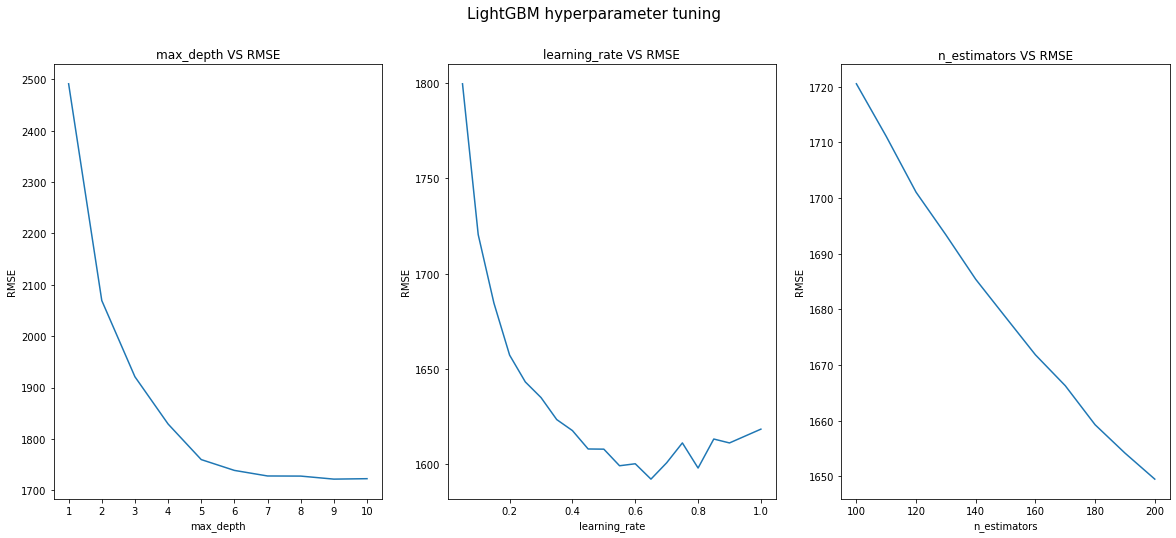

In [27]:
# Visualize hyperparameter optimization (on training set)
fig, ax = plt.subplots(1, 3, figsize=(20,8))

ax[0].plot(depth_lgb, depth_rmse_lgb)
ax[0].set_ylabel('RMSE')
ax[0].set_xlabel('max_depth')
ax[0].set_title('max_depth VS RMSE')
ax[0].set_xticks(range(1, 11))

ax[1].plot(learningrate_lgb, lrate_rmse_lgb)
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('learning_rate')
ax[1].set_title('learning_rate VS RMSE')

ax[2].plot(n_estimators_lgb, nest_rmse_lgb)
ax[2].set_ylabel('RMSE')
ax[2].set_xlabel('n_estimators')
ax[2].set_title('n_estimators VS RMSE')

plt.suptitle('LightGBM hyperparameter tuning', fontsize=15)
plt.show()

### CatBoost

In [28]:
# catboost varying learning_rate
lrate_cb = []
lrate_rmse_cb = []
for lrate in np.arange(0.05, 1.05, 0.05):
    model_cb = CatBoostRegressor(random_state=12345, loss_function='RMSE', iterations=100, learning_rate=lrate)
    model_cb.fit(X_train, y_train, cat_features=cat_features, verbose=0)
    predictions_cb = model_cb.predict(X_train)
    rmse = mean_squared_error(y_train, predictions_cb, squared=False)
    lrate_cb.append(lrate)
    lrate_rmse_cb.append(rmse)

In [29]:
# catboost varying depth
depth_cb = []
depth_rmse_cb = []
for dep in range(1, 11):
    model_cb = CatBoostRegressor(random_state=12345, loss_function='RMSE', iterations=100, depth=dep)
    model_cb.fit(X_train, y_train, cat_features=cat_features, verbose=0)
    predictions_cb = model_cb.predict(X_train)
    rmse = mean_squared_error(y_train, predictions_cb, squared=False)
    depth_cb.append(dep)
    depth_rmse_cb.append(rmse)

In [30]:
# catboost varying iterations
iter_cb = []
iter_rmse_cb = []
for iter in range(100, 201, 20):
    model_cb = CatBoostRegressor(random_state=12345, loss_function='RMSE', iterations=iter)
    model_cb.fit(X_train, y_train, cat_features=cat_features, verbose=0)
    predictions_cb = model_cb.predict(X_train)
    rmse = mean_squared_error(y_train, predictions_cb, squared=False)
    iter_cb.append(iter)
    iter_rmse_cb.append(rmse)

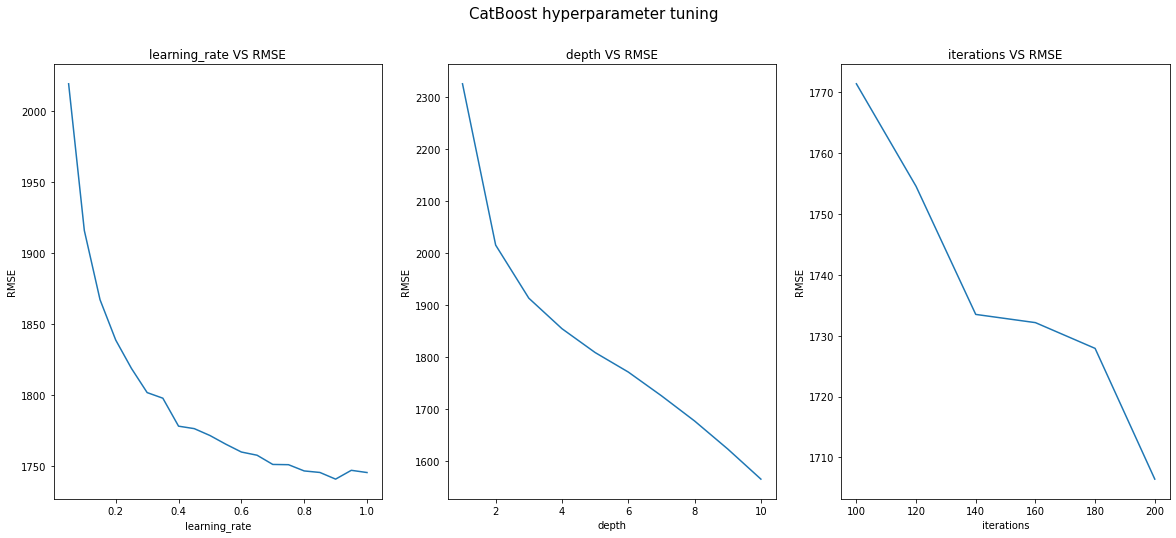

In [31]:
# Visualize hyperparameter optimization (on training set)
fig, ax = plt.subplots(1, 3, figsize=(20,8))

ax[0].plot(lrate_cb, lrate_rmse_cb)
ax[0].set_ylabel('RMSE')
ax[0].set_xlabel('learning_rate')
ax[0].set_title('learning_rate VS RMSE')

ax[1].plot(depth_cb, depth_rmse_cb)
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('depth')
ax[1].set_title('depth VS RMSE')

ax[2].plot(iter_cb, iter_rmse_cb)
ax[2].set_ylabel('RMSE')
ax[2].set_xlabel('iterations')
ax[2].set_title('iterations VS RMSE')

plt.suptitle('CatBoost hyperparameter tuning', fontsize=15)
plt.show()

## Model analysis

In [32]:
# train lightGBM regressor using GridSearchCV
param_grid_lgb = {
    'max_depth': list(range(5, 8)),
    'learning_rate': list(np.arange(0.1, 0.4, 0.05)),
    'n_estimators': list(range(170, 201, 10))
}

model_lgb = lgb.LGBMRegressor(random_state=12345)
grid_lgb = GridSearchCV(model_lgb, param_grid_lgb, cv=3, scoring='neg_root_mean_squared_error', verbose=0)

In [33]:
%%time
# measure run time lightGBM
grid_lgb.fit(X_train, y_train, categorical_feature=cat_features)
print(grid_lgb.best_params_)

C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\uland\AppData\Roaming\Python\Py

{'learning_rate': 0.20000000000000004, 'max_depth': 7, 'n_estimators': 200}
CPU times: total: 36min 35s
Wall time: 3min 6s


In [ ]:
# tuned paramters for lightGBM:
# learning_rate: 0.2
# max_depth: 7
# n_estimators: 200

Summary for lightGBM:
- Training run time: <b>3.5 min</b>

In [34]:
# train CatBoost regressor using GridSearchCV
param_grid_cb = {
    'learning_rate': list(np.arange(0.4, 0.65, 0.05))
}

model_cb = CatBoostRegressor(random_state=12345, loss_function='RMSE', iterations=200, depth=10)
grid_cb = GridSearchCV(model_cb, param_grid_cb, cv=3, scoring='neg_root_mean_squared_error', verbose=0)

In [35]:
%%time
# measure run time CatBoost
grid_cb.fit(X_train, y_train, cat_features=cat_features, verbose=0)
print(grid_cb.best_params_)

{'learning_rate': 0.4}
CPU times: total: 1h 1min 43s
Wall time: 8min 19s


In [36]:
# tuned paramters for CatBoost:
# learning_rate: 0.4
# iterations: 200
# depth: 10

Summary for CatBoostRegressor:
- Training run time: <b>8.2 min</b>

In [37]:
# XGBoost
param = {}
model_xgb = xgb.XGBRegressor(random_state=12345, verbosity=0)
grid_xgb = GridSearchCV(model_xgb, param, cv=3, scoring='neg_root_mean_squared_error', verbose=0)

In [38]:
%%time
# measure run time XGBoost
grid_xgb.fit(X_train_ohe, y_train_ohe)

CPU times: total: 18min 16s
Wall time: 1min 47s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=12345, ...),
             param_grid={}, scoring='neg_root_mean_squared_error')

In [39]:
# Print out best score from gridsearchCV of different models
print('LightGBM best score:', grid_lgb.best_score_)
print('CatBoost best score:', grid_cb.best_score_)
print('XGBoost best score:', grid_xgb.best_score_)

LightGBM best score: -1741.2184093529968
CatBoost best score: -1753.8751835829855
XGBoost best score: -1798.0057121779737


In [40]:
%%time
# measure run time lightGBM on prediction on test set
predictions_lgb = grid_lgb.predict(X_test)
rmse = mean_squared_error(y_test, predictions_lgb, squared=False)
print(f'RMSE: {rmse}')

RMSE: 1735.156502787253
CPU times: total: 1.48 s
Wall time: 139 ms


### Decision Tree vs Random Forest vs Linear Regression

Summary of results:

Training run times:
- Decision tree: 27.5 seconds
- Random forest: > 23 minutes
- Linear regression: < 5 seconds

Prediction run times:
- Decision tree: 136 ms
- Random forest: 302 ms
- Linear regression: < 5 seconds

RMSE metric:
- Decision tree: 2540 
- Random forest: 2345
- Linear regression: 3180

Ranking in terms of training run time: Linear Regression > Decision Tree > Random Forest

Ranking in terms of prediction run time: Linear Regression ~ Decision Tree > Random Forest

Ranking in terms of RMSE value: Random Forest > Decision Tree > Linear Regression

There's a balance of run time and better metrics. Random Forest takes considerably longer training and running time but results is the lowest with a RMSE of 2345. However, decision tree and linear regression models run fast but suffer from poorer accuracy. In this case, linear regression model performed the worst on this data set with RMSE of 3180.

### LightGBM vs CatBoost vs XGBoost

Ranking in terms of training run time: lightGBM > CatBoostRegressor

Ranking in terms of RMSE metric: lightGBM ~ CatBoostRegressor

Run time is very fast with lightGBM, considerably slower with CatBoost and XGBoost. However, faster than random forest method.

Across the board, all gradient boosting methods have considerably better RMSE values. 

Using LightGBM with tuned parameters have the fastest run time as well as the lowest RMSE value for the dataset. Tuning the hyperparameters takes considerable run time, but can achieve better RMSE metrics.

## Conclusion

Overall, with the used car data set, LightGBM method had the best properties in terms of quality of the prediction and speed of training and prediction. The mean and standard deviation of the `price` target is 4416 +/- 4514. Considering this, the method prediction had a RMSE value of 1735. Compared with non-gradient boosting methods, such as decision tree or linear regression, the respective RMSE for the predictions are 2540 and 3180, so the gradient boosting method is considerably better.

To summarize the workflow, the data set was prepared by removing duplicate rows, filled missing values, and categorical columns were encoded using one-hot encoding for models that require encoding. Next, non-gradient boosting and gradient boosting methods were evaluated, with hyperparameter tuning. Non-gradient boosting methods included DecisionTreeRegressor, RandomForestRegressor, and LinearRegression, while gradient boosting methods included LightGBM, CatBoost, and XGBoost. 